dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
dtype: int64
                      date  active_vehicles         trips       month  \
count                  354       354.000000    354.000000  354.000000   
mean   2015-01-30 00:00:00      1307.435028  11667.316384    1.474576   
min    2015-01-01 00:00:00       112.000000    629.000000    1.000000   
25%    2015-01-15 00:00:00       296.750000   2408.500000    1.000000   
50%    2015-01-30 00:00:00      1077.000000   9601.000000    1.000000   
75%    2015-02-14 00:00:00      1417.000000  13711.250000    2.000000   
max    2015-02-28 00:00:00      4395.000000  45858.000000    2.000000   
std                    NaN      1162.510626  10648.284865    0.500060   

              day      week  
count  354.000000     354.0  
mean    15.288136  5.135593  
min      1.000000       1.0  
25%      8.000000       3.0  
50%     15.000000       5.0  
75%     23.000000       7.0  
max

C:\Users\Sahithi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Sahithi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


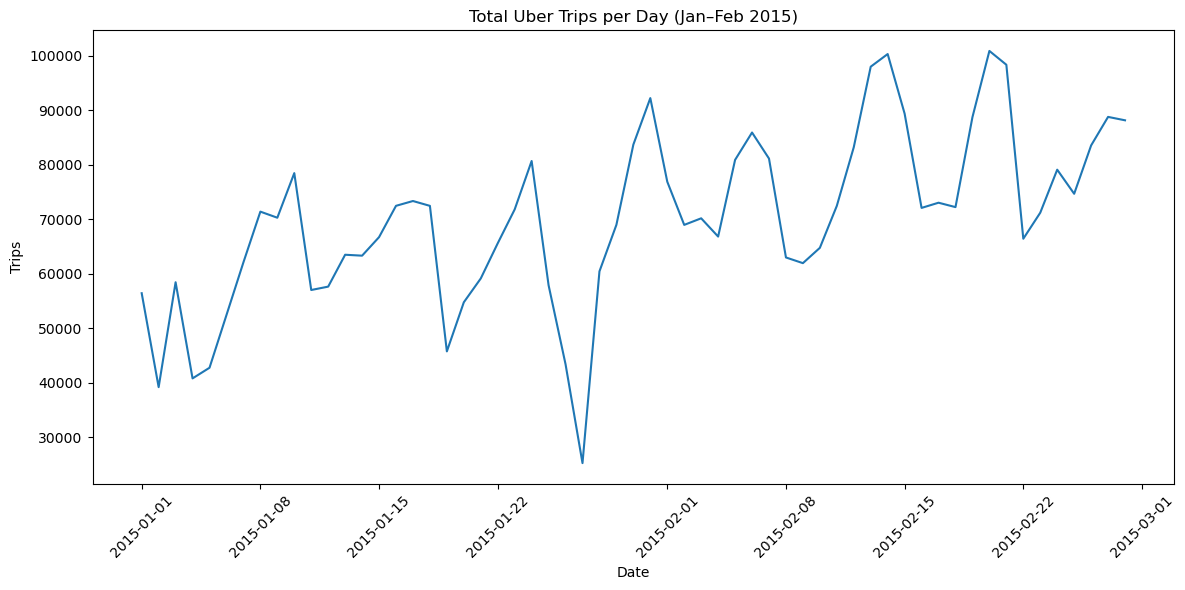

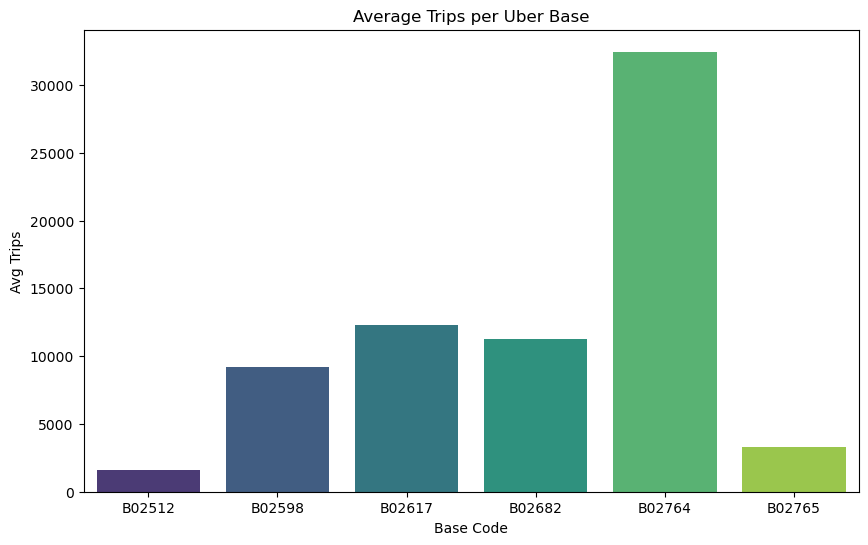

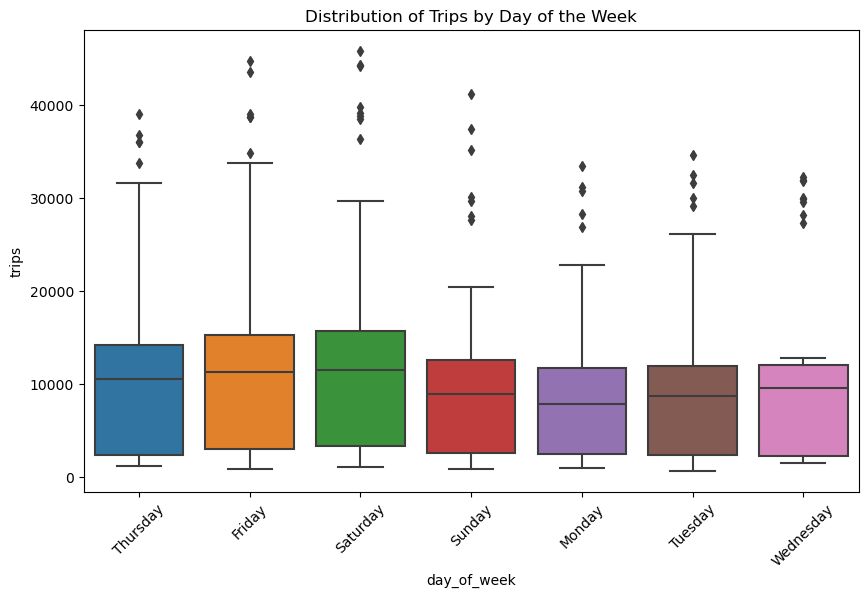

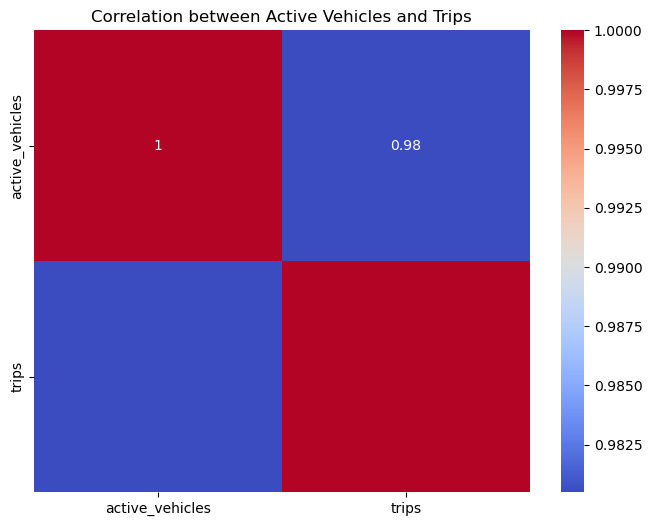

In [2]:
# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 2. LOAD AND CLEAN THE DATA

df = pd.read_csv(r"C:\Users\Sahithi\Downloads\Uber-Jan-Feb-FOIL (1).csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Check for nulls
print(df.isnull().sum())

# Standardize column names
df.columns = df.columns.str.lower()


# 3. FEATURE ENGINEERING

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.isocalendar().week


# 4. BASIC EDA

print(df.describe())

# Total trips per day
trips_per_day = df.groupby('date')['trips'].sum().reset_index()


# 5. VISUALIZATIONS


# Line plot: Total trips per day
plt.figure(figsize=(12,6))
sns.lineplot(data=trips_per_day, x='date', y='trips')
plt.title("Total Uber Trips per Day (Jan–Feb 2015)")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot: Average trips per base
plt.figure(figsize=(10,6))
sns.barplot(data=df.groupby('dispatching_base_number')['trips'].mean().reset_index(),
            x='dispatching_base_number', y='trips', palette='viridis')
plt.title("Average Trips per Uber Base")
plt.ylabel("Avg Trips")
plt.xlabel("Base Code")
plt.show()

# Boxplot: Trips by Day of Week
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='day_of_week', y='trips')
plt.title("Distribution of Trips by Day of the Week")
plt.xticks(rotation=45)
plt.show()


# 6. CORRELATION HEATMAP

plt.figure(figsize=(8,6))
sns.heatmap(df[['active_vehicles', 'trips']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Active Vehicles and Trips")
plt.show()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Encode day_of_week as categorical
df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

# Define X and y
X = df.drop(columns=['date', 'dispatching_base_number', 'trips'])
y = df['trips']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

MSE: 2054758.6089339904
R^2 Score: 0.9809443962547691


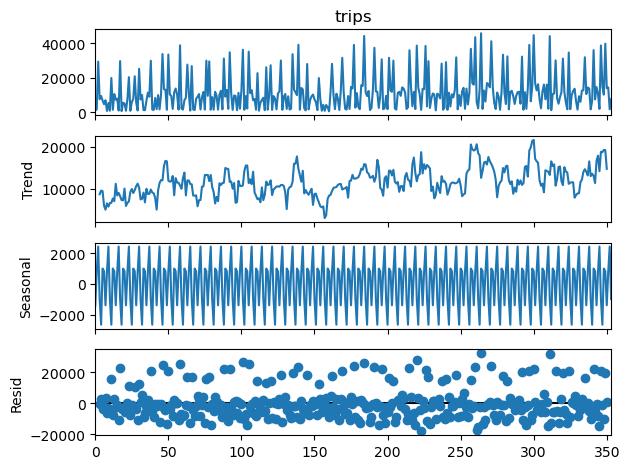

In [6]:
# 1. Fill missing values for daily total trips
df['trips'] = df['trips'].interpolate(method='linear')

# 2. Decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['trips'], model='additive', period=7)
decomposition.plot()
plt.tight_layout()
plt.show()


In [7]:
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Create features and target
window_size = 7  # one week
X, y = create_lagged_features(df['trips'].values, window_size)


In [8]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [10]:
!pip install xgboost
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# GBRT
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_test)


   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB 653.6 kB/s eta 0:03:50
   ---------------------------------------- 0.3/149.9 MB 2.9 MB/s eta 0:00:51
   ---------------------------------------- 0.6/149.9 MB 4.7 MB/s eta 0:00:32
   ---------------------------------------- 1.1/149.9 MB 5.9 MB/s eta 0:00:26
   ---------------------------------------- 1.5/149.9 MB 6.3 MB/s eta 0:00:24
    --------------------------------------- 2.1/149.9 MB 7.3 MB/s eta 0:00:21
    --------------------------------------- 2.5/149.9 MB 7.6 MB/s eta 0:00:20
    --------------------------------------- 3.0/149.9 MB 8.1 MB/s eta 0:00:19
    --------------------------------------- 3.3/149.9 MB 7.9 MB/s eta 0:00:19
   - -------------------------------------- 3.8/149.9 MB 8.0 MB/s eta 0:00:19
   - -------------------------------------- 3.9/149.9 MB 7.6 MB/s eta 0:00:2

In [11]:
# Ensemble: weighted average (you can fine-tune weights)
ensemble_pred = 0.4 * xgb_pred + 0.3 * rf_pred + 0.3 * gbr_pred

# MAPE Scores
print("XGBoost MAPE:", mean_absolute_percentage_error(y_test, xgb_pred))
print("Random Forest MAPE:", mean_absolute_percentage_error(y_test, rf_pred))
print("GBRT MAPE:", mean_absolute_percentage_error(y_test, gbr_pred))
print("Ensemble MAPE:", mean_absolute_percentage_error(y_test, ensemble_pred))


XGBoost MAPE: 1.3301168738401665
Random Forest MAPE: 1.2577476748796441
GBRT MAPE: 1.277696452194121
Ensemble MAPE: 1.28099323275585


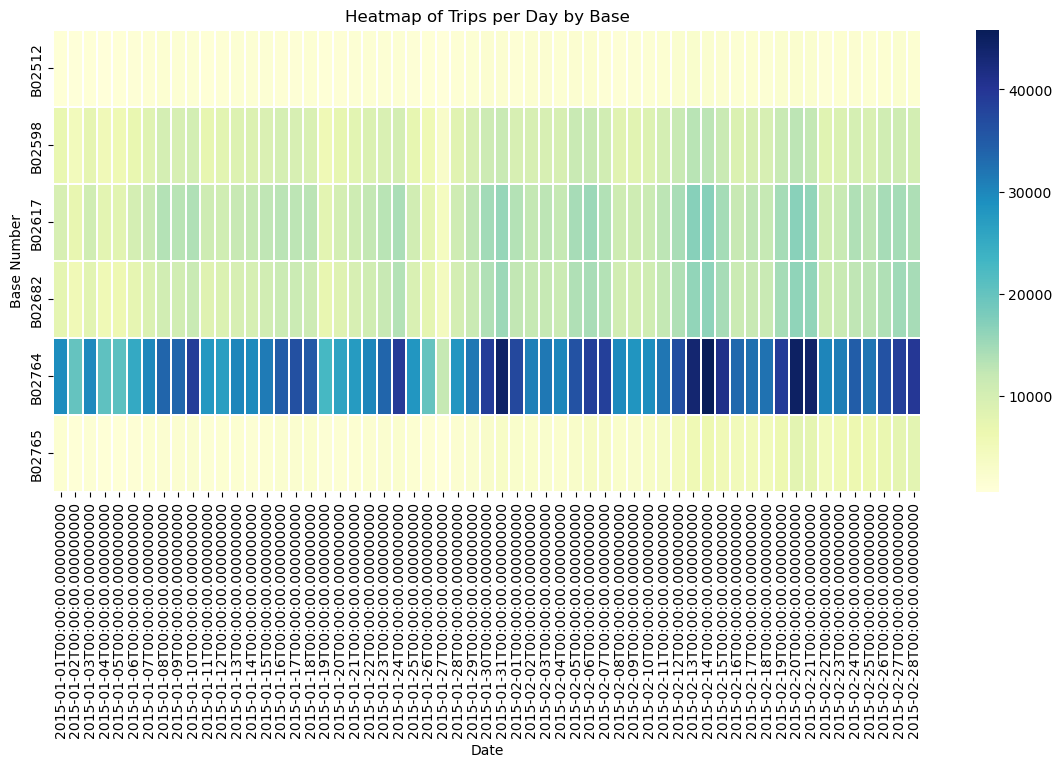

In [12]:
pivot = df.pivot_table(index='date', columns='dispatching_base_number', values='trips', aggfunc='sum')
plt.figure(figsize=(14,6))
sns.heatmap(pivot.T, cmap="YlGnBu", linecolor='white', linewidths=0.1)
plt.title('Heatmap of Trips per Day by Base')
plt.xlabel("Date")
plt.ylabel("Base Number")
plt.show()


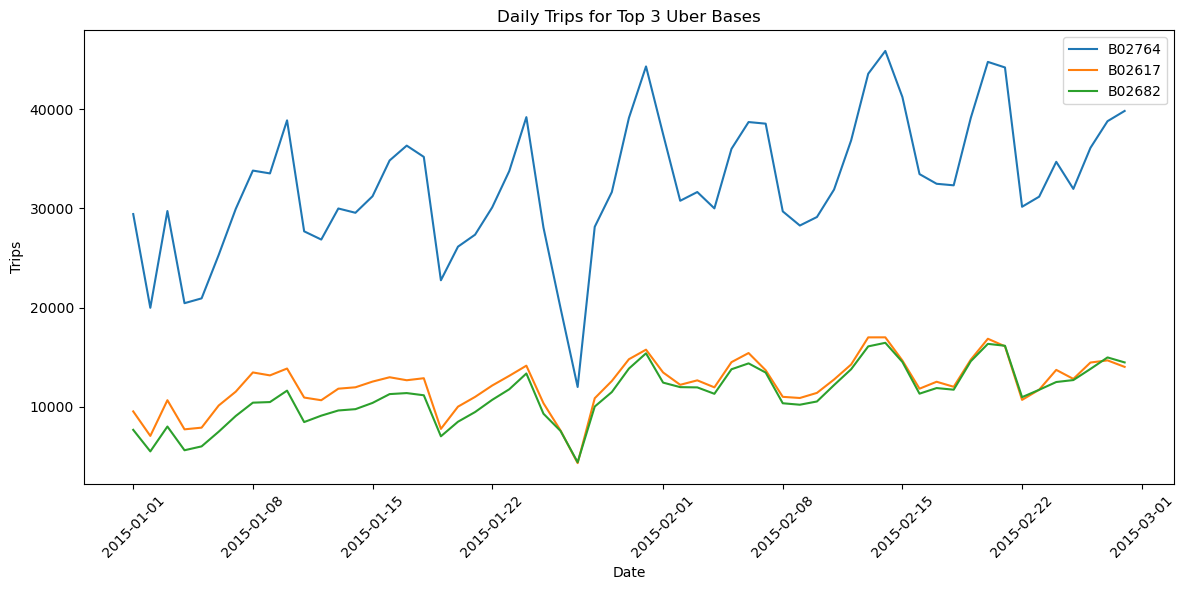

In [13]:
top_bases = df.groupby('dispatching_base_number')['trips'].sum().sort_values(ascending=False).head(3).index
plt.figure(figsize=(12,6))
for base in top_bases:
    temp = df[df['dispatching_base_number'] == base]
    daily = temp.groupby('date')['trips'].sum()
    plt.plot(daily.index, daily.values, label=base)

plt.title("Daily Trips for Top 3 Uber Bases")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


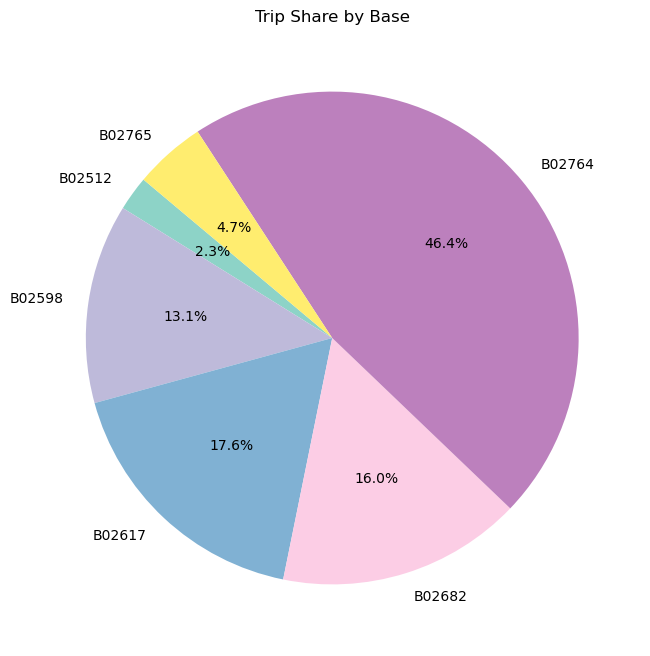

In [15]:
trip_share = df.groupby('dispatching_base_number')['trips'].sum()
plt.figure(figsize=(8,8))
trip_share.plot(kind='pie', autopct='%1.1f%%', startangle=140, colormap='Set3')
plt.ylabel('')
plt.title('Trip Share by Base')
plt.show()


C:\Users\Sahithi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Sahithi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


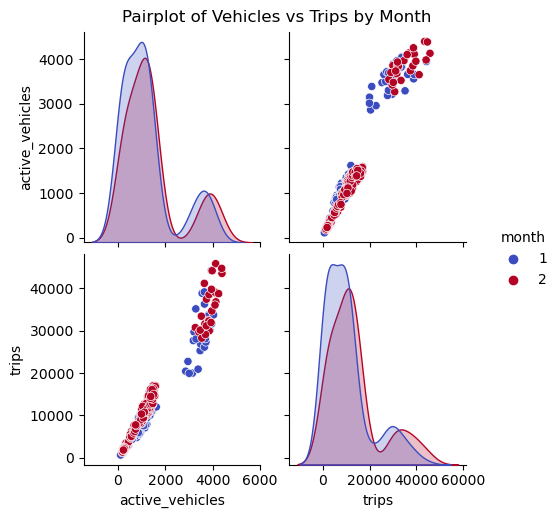

In [16]:
sns.pairplot(df[['active_vehicles', 'trips', 'month']], hue='month', palette='coolwarm')
plt.suptitle("Pairplot of Vehicles vs Trips by Month", y=1.02)
plt.show()
